In [1]:
import sys
sys.path.append('../src')
sys.path.append('../utils')

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from tslearn.datasets import UCR_UEA_datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import AddTime, LeadLag
from sigKer_fast import sig_kernel
from sigKer_torch import SigLoss, SigLoss_naive
from sigMMD_torch import SigMMD

In [2]:
def transform(paths, at=False, ll=False):
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
    return paths

In [180]:
data = UCR_UEA_datasets().list_multivariate_datasets()
name = 'UWaveGestureLibrary'

x_train, y_train, x_test, y_test = UCR_UEA_datasets().load_dataset(name)

# x_train = TimeSeriesScalerMinMax().fit_transform(x_train)
# x_test = TimeSeriesScalerMinMax().fit_transform(x_test)


subsample = 5
steps = 10
scale = 0.5
at, ll = True, False

x_train = x_train[:,::subsample,:]
x_test = x_test[:,::subsample,:]

y_train = torch.tensor(scale*np.array(transform(x_train[:,-steps:,:], at=at, ll=ll)), dtype=torch.double)
x_train = torch.tensor(scale*np.array(transform(x_train[:,:-steps,:], at=at, ll=ll)), dtype=torch.double)
y_test = torch.tensor(scale*np.array(transform(x_test[:,-steps:,:], at=at, ll=ll)), dtype=torch.double)
x_test = torch.tensor(scale*np.array(transform(x_test[:,:-steps,:], at=at, ll=ll)), dtype=torch.double)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([120, 53, 4])
torch.Size([120, 10, 4])
torch.Size([320, 53, 4])
torch.Size([320, 10, 4])


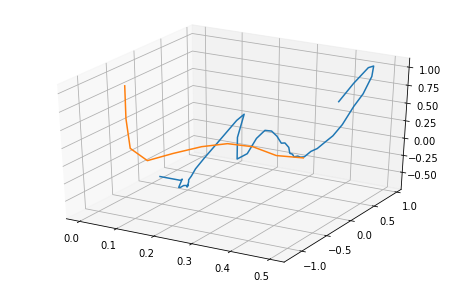

In [181]:
n = 0

fig = plt.figure(figsize=(8,5))

ax =  fig.add_subplot(projection='3d')
ax.plot3D(x_train[n][:,0], x_train[n][:,1], x_train[n][:,2])
ax.plot3D(y_train[n][:,0], y_train[n][:,1], y_train[n][:,2])
plt.show()

In [191]:
# batch_size
length_input, D = x_train[0].shape
length_output = y_train[0].shape[0]
length_hidden = 50

In [232]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.layer1 = nn.Linear(in_features=length_input, out_features=length_hidden, bias=True).double()
        self.layer2 = nn.Linear(in_features=length_hidden, out_features=length_hidden, bias=True).double()
        self.layer2_ = nn.Linear(in_features=length_hidden, out_features=length_hidden, bias=True).double()
        self.layer3 = nn.Linear(in_features=length_hidden, out_features=length_output, bias=True).double()
    def forward(self,x):
        x = x.transpose(1,2)
        x = self.layer1(x)
#         x = self.activation(x)
#         x = self.layer2(x)
#         x = self.activation(x)
#         x = self.layer2_(x)
#         x = self.activation(x)
        x = self.layer3(x)
        x = self.activation(x)
        return x.transpose(1,2)

In [233]:
net = Net()

In [251]:
batch_size = 50
# losses = []

In [252]:
# criterion = nn.MSELoss()
# criterion = SigLoss(0)
# criterion = SigLoss_naive(0)
criterion = SigMMD(0)

In [262]:
optimizer = optim.Adadelta(params=list(net.parameters()), lr=0.1)

In [263]:
for i in tqdm(range(1000)):
    net.zero_grad()
    rand_columns = torch.randperm(x_train.shape[0])[:batch_size]
    output = net(x_train[rand_columns])
    loss = criterion(output,y_train[rand_columns])
    loss.backward()
    optimizer.step()
    if i%100==0:
        print(loss.item())
    losses.append(loss.item())

<ipython-input-263-22fae1f357e8>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1000)):


0.4312144575205261
0.29645716480941964
0.3059572660025842
0.29545790833598407



KeyboardInterrupt: 

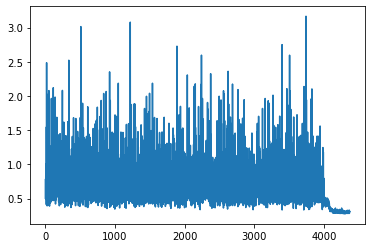

In [264]:
plt.plot(losses)
plt.show()

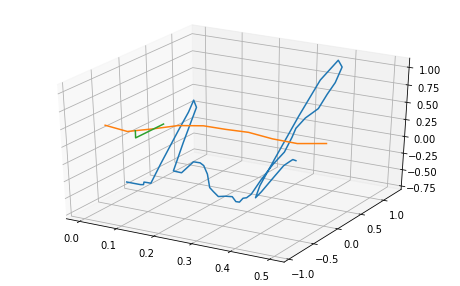

In [270]:
output = net(x_train)

n = 5

fig = plt.figure(figsize=(8,5))
ax =  fig.add_subplot(projection='3d')
ax.plot3D(x_train[n][:,0], x_train[n][:,1], x_train[n][:,2])
ax.plot3D(y_train[n][:,0], y_train[n][:,1], y_train[n][:,2])
ax.plot3D(output.detach().numpy()[n][:,0], output.detach().numpy()[n][:,1], output.detach().numpy()[n][:,2])
plt.show()

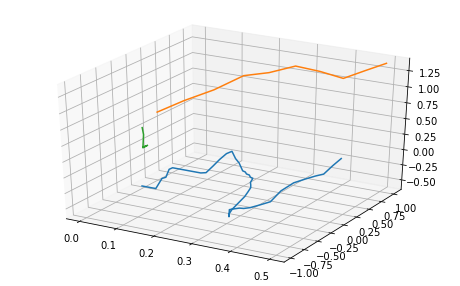

In [266]:
output = net(x_test)

n = 2

fig = plt.figure(figsize=(8,5))

ax =  fig.add_subplot(projection='3d')
ax.plot3D(x_test[n][:,0], x_test[n][:,1], x_test[n][:,2])
ax.plot3D(y_test[n][:,0], y_test[n][:,1], y_test[n][:,2])
ax.plot3D(output.detach().numpy()[n][:,0], output.detach().numpy()[n][:,1], output.detach().numpy()[n][:,2])
plt.show()